# Instacart Product recommendations
Kaggle Competition: https://www.kaggle.com/c/instacart-market-basket-analysis

In [1]:
# ! pip install shap


In [2]:
import pandas as pd
pd.set_option('display.width', 1000)

# Load Data

In [3]:
products = pd.read_csv("datasets/instacart-market-basket-analysis/products.csv")
print(products.head(2))
print(f"{products.shape}")

departments = pd.read_csv("datasets/instacart-market-basket-analysis/departments.csv")
print(departments.head(2))
print(f"{departments.shape}")

aisles = pd.read_csv("datasets/instacart-market-basket-analysis/aisles.csv")
print(aisles.head(2))
print(f"{aisles.shape}")


   product_id                product_name  aisle_id  department_id
0           1  Chocolate Sandwich Cookies        61             19
1           2            All-Seasons Salt       104             13
(49688, 4)
   department_id department
0              1     frozen
1              2      other
(21, 2)
   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses
(134, 2)


In [4]:
orders = pd.read_csv("datasets/instacart-market-basket-analysis/orders.csv")
print(orders.head(2))
print(f"{orders.shape}")

orders_products_prior = pd.read_csv("datasets/instacart-market-basket-analysis/order_products__prior.csv")
print(orders_products_prior.head(2))
print(f"{orders_products_prior.shape}")

orders_products_train = pd.read_csv("datasets/instacart-market-basket-analysis/order_products__train.csv")
print(orders_products_train.head(2))
print(f"{orders_products_train.shape}")


   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order
0   2539329        1    prior             1          2                  8                     NaN
1   2398795        1    prior             2          3                  7                    15.0
(3421083, 7)
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
(32434489, 4)
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
(1384617, 4)


In [5]:
# Goal is to predict which previously ordered items will be in next user order
# Extract a small sample set and perform EDA
# Featues
# Model Design:
# Input : [User , Product] -> [Probability of ordering again]
# 
# Features:
# User: Counts: Total Orders, Order frequency, Avg unique products, Avg total items,       
# Product: Avg order items, Order frequency
# User-product: Order frequency per order, Order frequency per days
# Label: Reordered

# User Features

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [7]:
# exrtact prior orders for processing features
prior_orders = orders[orders.eval_set=='prior']

In [8]:
u_total_orders = prior_orders.groupby('user_id')['order_id'].count().reset_index(name='u_total_orders')
print(u_total_orders.head(2))
u_history = prior_orders.groupby('user_id')['days_since_prior_order'].sum().reset_index(name='u_history_days')
print(u_history.head(2))

u_total_orders = u_total_orders.merge(u_history, on='user_id', how='left')
u_total_orders['u_order_frequency_days'] = u_total_orders['u_history_days']/u_total_orders['u_total_orders']
u_features = u_total_orders

print(u_features.head(2))
print(u_features.shape)

   user_id  u_total_orders
0        1              10
1        2              14
   user_id  u_history_days
0        1           176.0
1        2           198.0
   user_id  u_total_orders  u_history_days  u_order_frequency_days
0        1              10           176.0               17.600000
1        2              14           198.0               14.142857
(206209, 4)


# Product Features

In [9]:
prior_order_products = pd.merge(prior_orders, orders_products_prior, on="order_id", how="left")
print(prior_order_products.head(2))
print(f"{prior_order_products.shape}")

p_total_orders = prior_order_products.groupby('product_id')['order_id'].count().reset_index(name='p_total_orders')
print(p_total_orders.head(2))

p_order_frequency_per_order = prior_order_products.groupby('product_id')['reordered'].mean().reset_index(name='p_reorder_rate_per_order')
print(p_order_frequency_per_order.head(2))

p_features = p_total_orders.merge(p_order_frequency_per_order, on='product_id', how='left')
print(p_features.head(2))
print(p_features.shape)

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  reordered
0   2539329        1    prior             1          2                  8                     NaN         196                  1          0
1   2539329        1    prior             1          2                  8                     NaN       14084                  2          0
(32434489, 10)
   product_id  p_total_orders
0           1            1852
1           2              90
   product_id  p_reorder_rate_per_order
0           1                  0.613391
1           2                  0.133333
   product_id  p_total_orders  p_reorder_rate_per_order
0           1            1852                  0.613391
1           2              90                  0.133333
(49677, 3)


# User x Product Features

In [10]:
uxp_reorder_rate = prior_order_products.groupby(['user_id', 'product_id'])['reordered'].mean().reset_index(name='uxp_reorder_rate_per_order')

# uxp_reorders = prior_order_products.groupby(['user_id', 'product_id']).size().reset_index(name='uxp_total_orders')

# uxp_reorder_rate = uxp_reorder_rate.merge(uxp_reorders, on=['user_id', 'product_id'], how='left')

print(uxp_reorder_rate.head(2))
print(uxp_reorder_rate.shape)


   user_id  product_id  uxp_reorder_rate_per_order
0        1         196                    0.900000
1        1       10258                    0.888889
(13307953, 3)


# Build Train Data

In [11]:
# orders train
# combine with user, product and uxp features
# remove unnecessayr columns
# split to train and test

orders_train = orders[orders.eval_set=='train']
print(orders_train.shape)

order_products_train = pd.merge(orders_train, orders_products_train, on='order_id', how='left')
print(order_products_train.head(2))
print(order_products_train.shape)

# merge user feaures
features_dataset = order_products_train.merge(u_features, on='user_id', how='left')
print(features_dataset.head(2))

# merge product features
features_dataset = features_dataset.merge(p_features, on='product_id', how='left')
print(features_dataset.head(2))

# merge uxp features
features_dataset = features_dataset.merge(uxp_reorder_rate, on=['user_id', 'product_id'], how='left')
print(features_dataset.head(2))

# remove unwanted features
features_dataset = features_dataset.drop(['eval_set', 'order_id', 'product_id', 'user_id'], axis=1)

features_dataset["p_reorder_rate_per_day"] = features_dataset["p_reorder_rate_per_order"] * features_dataset["u_order_frequency_days"]

print(features_dataset.head(10))

(131209, 7)
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  reordered
0   1187899        1    train            11          4                  8                    14.0         196                  1          1
1   1187899        1    train            11          4                  8                    14.0       25133                  2          1
(1384617, 10)
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  reordered  u_total_orders  u_history_days  u_order_frequency_days
0   1187899        1    train            11          4                  8                    14.0         196                  1          1              10           176.0                    17.6
1   1187899        1    train            11          4                  8                    14.0       25133                  2          1              10       

In [12]:
# print Nan values
print(features_dataset.isnull().sum())
features_dataset = features_dataset.fillna(0)
features_dataset.describe()

order_number                       0
order_dow                          0
order_hour_of_day                  0
days_since_prior_order             0
add_to_cart_order                  0
reordered                          0
u_total_orders                     0
u_history_days                     0
u_order_frequency_days             0
p_total_orders                     9
p_reorder_rate_per_order           9
uxp_reorder_rate_per_order    555793
p_reorder_rate_per_day             9
dtype: int64


,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,u_total_orders,u_history_days,u_order_frequency_days,p_total_orders,p_reorder_rate_per_order,uxp_reorder_rate_per_order,p_reorder_rate_per_day
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.709141e+01,2.701392e+00,1.357759e+01,1.706613e+01,8.758044e+00,5.985944e-01,1.609141e+01,1.620440e+02,1.275514e+01,3.434516e+04,5.789575e-01,3.120933e-01,7.356408e+00
std,1.661404e+01,2.167646e+00,4.238458e+00,1.042642e+01,7.423936e+00,4.901829e-01,1.661404e+01,1.050812e+02,5.290628e+00,7.765599e+04,1.533320e-01,3.771793e-01,3.670238e+00
min,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.000000e+00,1.000000e+01,7.000000e+00,3.000000e+00,0.000000e+00,5.000000e+00,6.900000e+01,8.452381e+00,1.425000e+03,4.938119e-01,0.000000e+00,4.497901e+00
50%,1.100000e+01,3.000000e+00,1.400000e+01,1.500000e+01,7.000000e+00,1.000000e+00,1.000000e+01,1.400000e+02,1.253333e+01,6.220000e+03,6.017316e-01,0.000000e+00,6.926621e+00
75%,2.100000e+01,5.000000e+00,1.700000e+01,3.000000e+01,1.200000e+01,1.000000e+00,2.000000e+01,2.480000e+02,1.685714e+01,2.672100e+04,6.884462e-01,6.666667e-01,9.844176e+00
max,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,8.000000e+01,1.000000e+00,9.900000e+01,3.650000e+02,2.690909e+01,4.725650e+05,9.411765e-01,9.898990e-01,2.214190e+01


In [13]:
features_dataset.groupby('reordered').size()

reordered
0    555793
1    828824
dtype: int64

In [14]:
# SPlit and train
from sklearn.model_selection import train_test_split
RANDOM_STATE = 7
TEST_SIZE = 0.2 

train, test = train_test_split(features_dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train = train.drop('reordered', axis=1)
Y_train = train['reordered']

X_test = test.drop('reordered', axis=1)
Y_test = test['reordered']


In [15]:
def metrics(Y_test, Y_pred):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    print(f"Confusion Matrix: \n{confusion_matrix(Y_test, Y_pred)}")
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(f"Precision: {precision_score(Y_test, Y_pred)}")
    print(f"Recall: {recall_score(Y_test, Y_pred)}")
    print(f"F1 Score: {f1_score(Y_test, Y_pred)}")

# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



model = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)



/opt/homebrew/Caskroom/miniconda/base/envs/interview_prep/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix: 
[[ 60081  51139]
 [ 32216 133488]]
Accuracy: 0.6989968366772111
Precision: 0.723014510337058
Recall: 0.8055810360643074
F1 Score: 0.7620678729544346


# Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10, 
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)



Confusion Matrix: 
[[110148   1072]
 [ 46288 119416]]
Accuracy: 0.8289783478499516
Precision: 0.9911028484164398
Recall: 0.7206585236325014
F1 Score: 0.834516688097501


# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10, 
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)


Confusion Matrix: 
[[109295   1925]
 [ 45576 120128]]
Accuracy: 0.8284691828805015
Precision: 0.9842281631750142
Recall: 0.7249553420557138
F1 Score: 0.8349266916182752


# Gradient Boosted Trees

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier(
    loss='log_loss',
    n_estimators=10,
    max_depth=10, 
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
)
gbc_model.fit(X_train, Y_train)
Y_pred = gbc_model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)



Confusion Matrix: 
[[107558   3662]
 [ 43697 122007]]
Accuracy: 0.8289819589490257
Precision: 0.9708599575074203
Recall: 0.7362948389900063
F1 Score: 0.8374626338061523


# Plot a Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

decisionTreeClassifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
)
decisionTreeClassifier.fit(X_train, Y_train)
Y_pred = decisionTreeClassifier.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)

Confusion Matrix: 
[[110148   1072]
 [ 46288 119416]]
Accuracy: 0.8289783478499516
Precision: 0.9911028484164398
Recall: 0.7206585236325014
F1 Score: 0.834516688097501


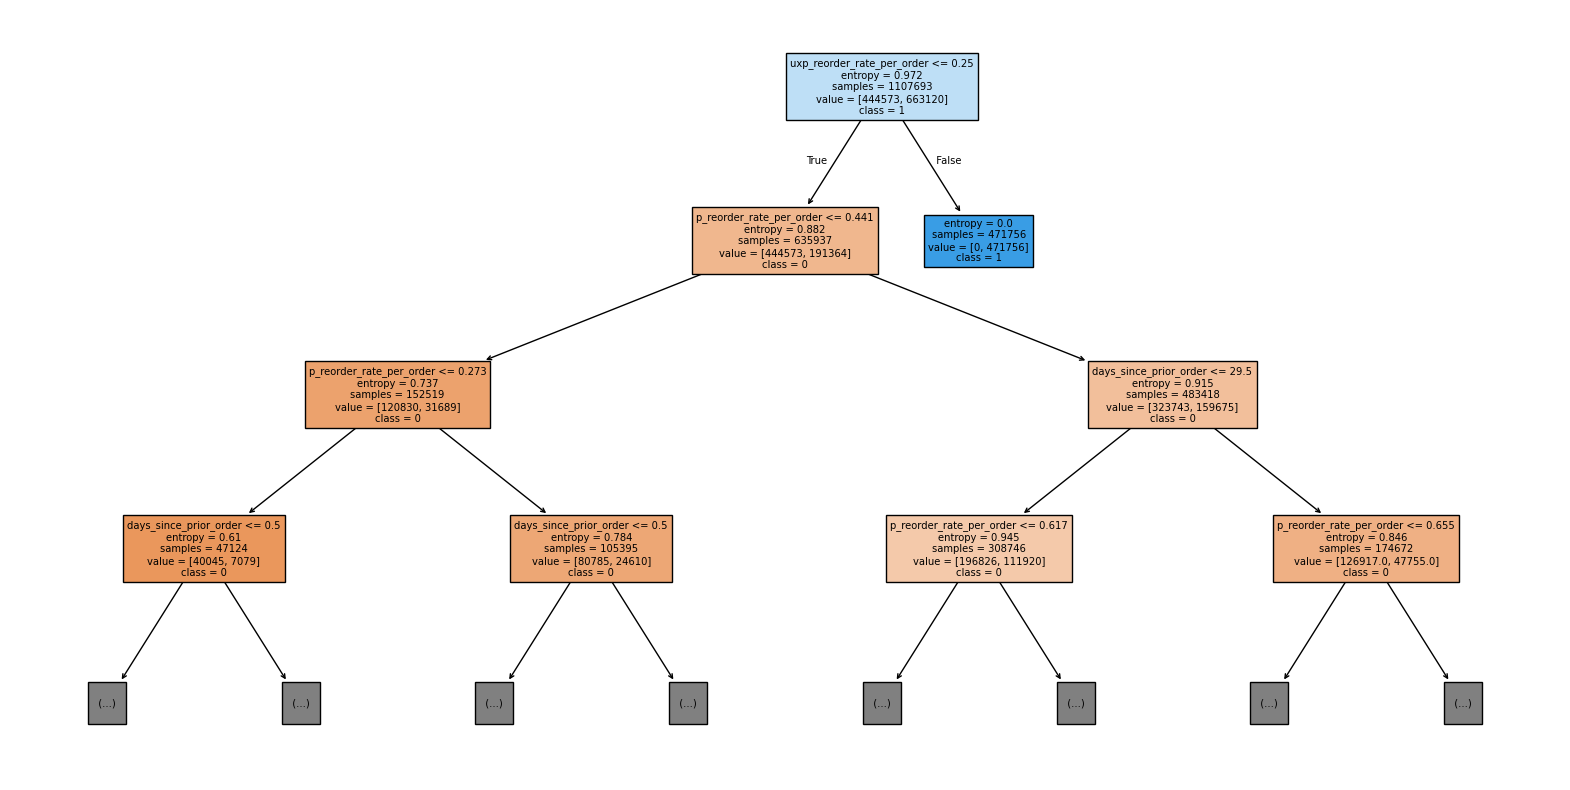

In [21]:
from sklearn import tree
import matplotlib.pyplot as plt
# plot a large image of the tree

plt.figure(figsize=(20, 10))  
tree.plot_tree(
    decisionTreeClassifier, 
    max_depth=3, 
    feature_names = X_train.columns, 
    class_names = ['0', '1'],
    filled=True
)
plt.show()

In [22]:
# feature importances
importances = decisionTreeClassifier.feature_importances_

# sort the importances
sorted_index = importances.argsort()

# create labels
labels = X_train.columns[sorted_index]

# create plot
for i in range(len(sorted_index) - 1, -1, -1):
    print(f"{labels[i]} \t {importances[sorted_index[i]].round(4)}")

uxp_reorder_rate_per_order 	 0.9566
p_reorder_rate_per_order 	 0.0195
days_since_prior_order 	 0.0103
add_to_cart_order 	 0.0043
p_total_orders 	 0.0023
u_total_orders 	 0.0018
u_history_days 	 0.0016
order_number 	 0.0011
p_reorder_rate_per_day 	 0.001
u_order_frequency_days 	 0.0009
order_hour_of_day 	 0.0004
order_dow 	 0.0001


In [23]:
# encode dow with one hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
dow_encoded = encoder.fit_transform(features_dataset[['order_dow']]).toarray()
dow_encoded = pd.DataFrame(dow_encoded, columns=[f"dow_{i}" for i in range(dow_encoded.shape[1])])

features_dataset = pd.concat([features_dataset, dow_encoded], axis=1)

# remove dow
features_dataset = features_dataset.drop('order_dow', axis=1)


def get_train_test_split(features_dataset):
    train, test = train_test_split(features_dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train = train.drop('reordered', axis=1)
    Y_train = train['reordered']

    X_test = test.drop('reordered', axis=1)
    Y_test = test['reordered']
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = get_train_test_split(features_dataset)

In [24]:
lr = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)

/opt/homebrew/Caskroom/miniconda/base/envs/interview_prep/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix: 
[[ 48999  62221]
 [ 23599 142105]]
Accuracy: 0.6900954774595196
Precision: 0.6954817301762869
Recall: 0.8575834017283831
F1 Score: 0.7680728589573819


In [25]:
# Encode hour of day to early morning, morning, afternoon, evening, night

def encode_hour_of_day(hour):
    if hour < 6:
        return 'early_morning'
    elif hour < 12:
        return 'morning'
    elif hour < 18:
        return 'afternoon'
    elif hour < 21:
        return 'evening'
    else:
        return 'night'

features_dataset['order_hour_of_day'] = features_dataset['order_hour_of_day'].apply(encode_hour_of_day)

# encode hour of day with one hot encoding
encoder = OneHotEncoder()
hour_encoded = encoder.fit_transform(features_dataset[['order_hour_of_day']]).toarray()
hour_encoded = pd.DataFrame(hour_encoded, columns=[f"hour_{i}" for i in range(hour_encoded.shape[1])])

features_dataset = pd.concat([features_dataset, hour_encoded], axis=1)

# remove hour of day
features_dataset = features_dataset.drop('order_hour_of_day', axis=1)

X_train, Y_train, X_test, Y_test = get_train_test_split(features_dataset)

In [26]:
lr = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)

/opt/homebrew/Caskroom/miniconda/base/envs/interview_prep/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix: 
[[ 63407  47813]
 [ 34820 130884]]
Accuracy: 0.7016040502087215
Precision: 0.7324353514608527
Recall: 0.7898662675614349
F1 Score: 0.7600674794788633


In [27]:
decisionTreeClassifier = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
)
decisionTreeClassifier.fit(X_train, Y_train)
Y_pred = decisionTreeClassifier.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
metrics(Y_test, Y_pred)

Confusion Matrix: 
[[110194   1026]
 [ 46313 119391]]
Accuracy: 0.829054180930508
Precision: 0.9914796083609457
Recall: 0.7205076521991021
F1 Score: 0.8345490194707833


In [28]:
# feature importances
importances = decisionTreeClassifier.feature_importances_

# sort the importances
sorted_index = importances.argsort()

# create labels
labels = X_train.columns[sorted_index]

# create plot
for i in range(len(sorted_index) - 1, -1, -1):
    print(f"{labels[i]} \t {importances[sorted_index[i]].round(4)}")

uxp_reorder_rate_per_order 	 0.9568
p_reorder_rate_per_order 	 0.0195
days_since_prior_order 	 0.0103
add_to_cart_order 	 0.0043
p_total_orders 	 0.0024
order_number 	 0.002
u_history_days 	 0.0015
u_order_frequency_days 	 0.001
p_reorder_rate_per_day 	 0.0009
u_total_orders 	 0.0008
dow_4 	 0.0001
hour_2 	 0.0001
dow_5 	 0.0001
hour_3 	 0.0
dow_3 	 0.0
hour_0 	 0.0
dow_0 	 0.0
hour_1 	 0.0
dow_6 	 0.0
dow_1 	 0.0
dow_2 	 0.0
hour_4 	 0.0
